# Bank Data Analysis

Import Required Libraries

In [ ]:
# Install the required libraries
!pip install --quiet pyspark==3.5.4 pandas==2.2.2

In [ ]:
# Import required libraries
import logging
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
# Import PySpark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round, count, when, isnull, sum

In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("BankingDataAnalysis") \
    .getOrCreate()

#**1. Data Preparation**


The data can be accessed from the wikipedia link. The page features data regarding global banking data.

Utilise the pandas method to read tables from the html document
and extract the requried data consists of a structured format.

Before performing any analysis, it is crucial to prepare the data to ensure consistency, and efficiency in processing.

In [ ]:
# Initialize Spark session

# URL of the Wikipedia page
url = "https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks"

# Use pandas to read all HTML tables from the page
tables = pd.read_html(url, header=0)

# Load the correct table (Table 1)
df = tables[1]
print(df.head())

# Convert pandas DataFrame to PySpark DataFrame
df_spark = spark.createDataFrame(df)

# Rename columns
df_spark = df_spark.withColumnRenamed("Rank", "rank") \
                   .withColumnRenamed("Bank name", "bank_name") \
                   .withColumnRenamed("Market cap (US$ billion)", "market_cap")

# Show the first few rows of the PySpark
df_spark.show()

# Print the schema of the DataFrame
df_spark.printSchema()

# Configure logging
logging.basicConfig(level=logging.INFO)

   Rank                                Bank name  Market cap (US$ billion)
0     1                           JPMorgan Chase                    432.92
1     2                          Bank of America                    231.52
2     3  Industrial and Commercial Bank of China                    194.56
3     4               Agricultural Bank of China                    160.68
4     5                                HDFC Bank                    157.91
+----+--------------------+----------+
|rank|           bank_name|market_cap|
+----+--------------------+----------+
|   1|      JPMorgan Chase|    432.92|
|   2|     Bank of America|    231.52|
|   3|Industrial and Co...|    194.56|
|   4|Agricultural Bank...|    160.68|
|   5|           HDFC Bank|    157.91|
|   6|         Wells Fargo|    155.87|
|   7|   HSBC Holdings PLC|     148.9|
|   8|      Morgan Stanley|    140.83|
|   9|China Constructio...|    139.82|
|  10|       Bank of China|    136.81|
+----+--------------------+----------+

roo

Load the data for exchange rates

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the exchange rate data
exchange_rates_df = spark.read.csv("/content/drive/MyDrive/upgrad/BankingAnalysis/data/exchange_rate.csv", header=True, inferSchema=True)

# Show the first few rows of the exchange rate data to verify
exchange_rates_df.show()

# Print the schema of the exchange rate data
exchange_rates_df.printSchema()


+--------+-----+
|Currency| Rate|
+--------+-----+
|     EUR| 0.93|
|     GBP|  0.8|
|     INR|82.95|
+--------+-----+

root
 |-- Currency: string (nullable = true)
 |-- Rate: double (nullable = true)



#**2. Data Cleaning**

##**2.1 Handle Missing Values**


In [ ]:
# Print the schema to check data types
df_spark.printSchema()

root
 |-- rank: long (nullable = true)
 |-- bank_name: string (nullable = true)
 |-- market_cap: double (nullable = true)



In [ ]:
# Check for missing values

# Create a list of sum expressions, one per column
null_counts = [sum(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns]

# Select them in one row
df_spark.select(*null_counts).show()

+----+---------+----------+
|rank|bank_name|market_cap|
+----+---------+----------+
|   0|        0|         0|
+----+---------+----------+



In [ ]:
# Drop rows with missing values
df_clean = df_spark.dropna()

##**2.2 Fixing Columns**


The Market cap is already in numeric so no conversion needed.

In [ ]:
# Count the total number of rows
total_rows = df_clean.count()
print("The total number of rows: ", total_rows)

# Check if there are duplicates
duplicates = df_clean.dropDuplicates()
duplicate_count = total_rows - duplicates.count()
print("The number of duplicate rows: ", duplicate_count)


The total number of rows:  10
The number of duplicate rows:  0


##**2.2 Handle Outliers**


In [ ]:
# Write code for outlier analysis
from pyspark.sql.functions import col, expr

# Compute Q1 and Q3
quantiles = df_clean.approxQuantile("market_cap", [0.25, 0.75], 0.05)  # [Q1, Q3]
Q1, Q3 = quantiles
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df_clean.filter((col("market_cap") < lower_bound) | (col("market_cap") > upper_bound))
outliers.show()

+----+--------------+----------+
|rank|     bank_name|market_cap|
+----+--------------+----------+
|   1|JPMorgan Chase|    432.92|
+----+--------------+----------+



#**3. Exploratory Data Analysis**


##**3.1. Conversion from PySpark to Pandas DataFrame**

Convert PySpark DataFrame to Pandas DataFrame for visualization

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
df_pd = df_clean.toPandas()

##**3.2. Market Capitalization**

Analyze the distribution of market capitalization using a histogram

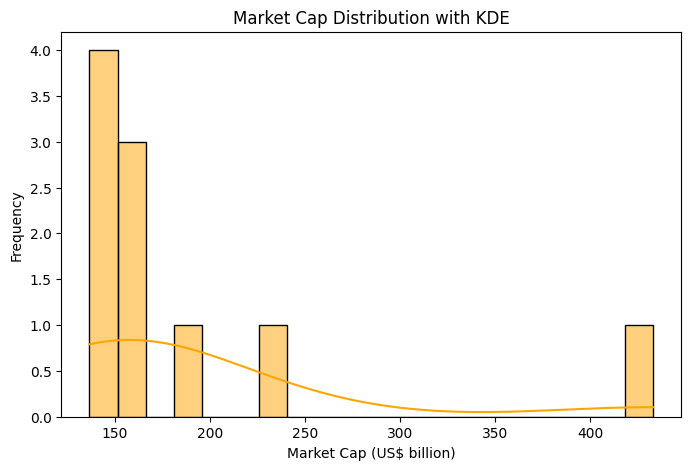

In [ ]:
# Distribution of Market Cap (US$ Billion)
plt.figure(figsize=(8,5))

# Set the style for seaborn
sns.histplot(df_pd["market_cap"], bins=20, kde=True, color='orange')

# Plot the distribution of market cap
plt.title("Market Cap Distribution with KDE")
plt.xlabel("Market Cap (US$ billion)")
plt.ylabel("Frequency")
plt.show()


##**3.3. Top 10 Banks**

Identify the top 10 banks by market capitalization using a bar chart

+----+--------------------+----------+
|rank|           bank_name|market_cap|
+----+--------------------+----------+
|   1|      JPMorgan Chase|    432.92|
|   2|     Bank of America|    231.52|
|   3|Industrial and Co...|    194.56|
|   4|Agricultural Bank...|    160.68|
|   5|           HDFC Bank|    157.91|
|   6|         Wells Fargo|    155.87|
|   7|   HSBC Holdings PLC|     148.9|
|   8|      Morgan Stanley|    140.83|
|   9|China Constructio...|    139.82|
|  10|       Bank of China|    136.81|
+----+--------------------+----------+



/tmp/ipython-input-1267205785.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="bank_name", y="market_cap", data=top10, palette="Blues_d")


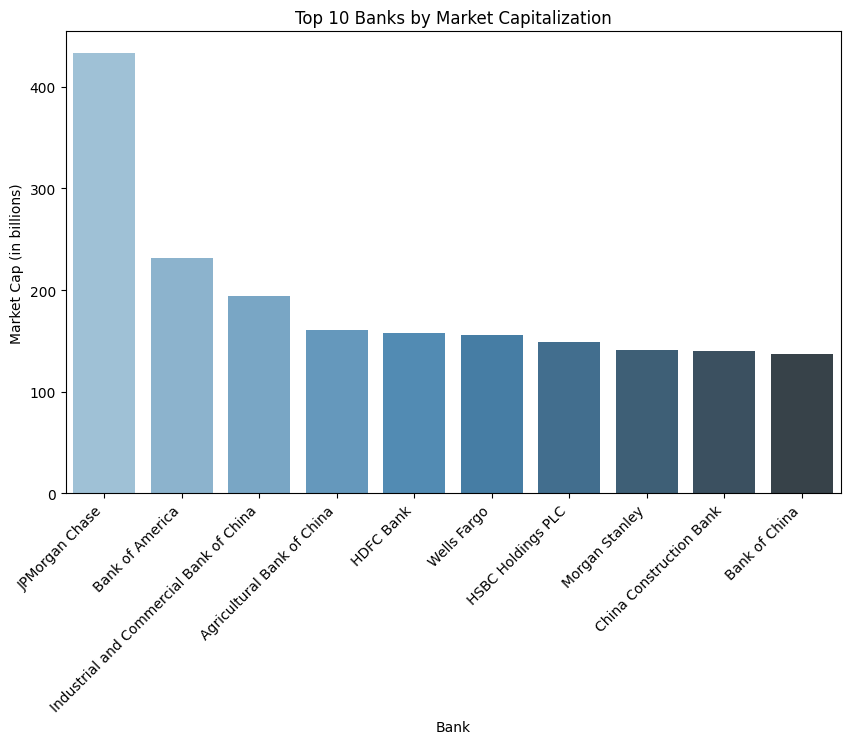

In [ ]:
# Top 10 Banks by Market Cap

# Sort the DataFrame by market cap in descending order
df_sorted = df_clean.orderBy(col("market_cap").desc())
df_sorted.show()

# Plot the top 10 banks by market cap
top10 = df_sorted.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(x="bank_name", y="market_cap", data=top10, palette="Blues_d")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Banks by Market Capitalization")
plt.ylabel("Market Cap (in billions)")
plt.xlabel("Bank")
plt.show()

##**3.4. Market Cap vs Bank Ranking**

Visualize the relationship between market capitalization and bank ranking using a scatter plot

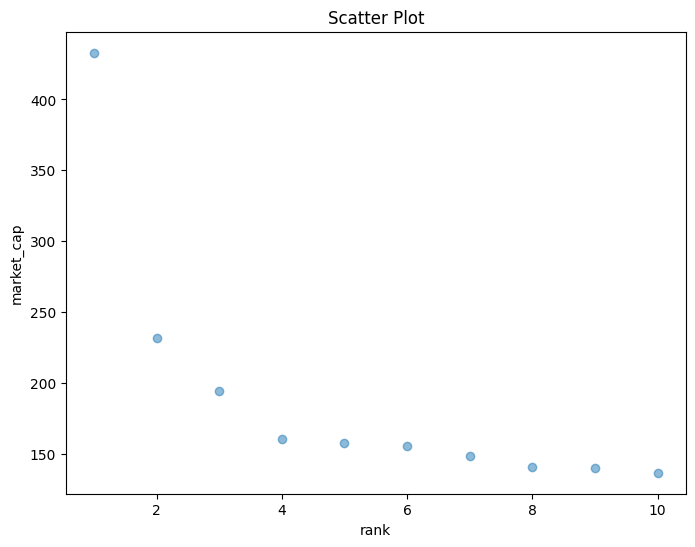

In [ ]:
# Market Cap vs Rank
plt.figure(figsize=(8,6))
plt.scatter(df_pd["rank"], df_pd["market_cap"], alpha=0.5)
plt.xlabel("rank")
plt.ylabel("market_cap")
plt.title("Scatter Plot")
plt.show()
# Plot market cap vs rank


##**3.5. Market Cap Analysis**

Use a boxplot to examine the spread and outliers in market capitalization.

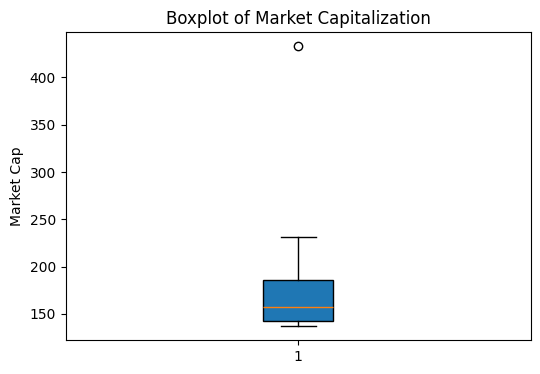

In [ ]:
# Boxplot of Market Cap
#To show the spread and outliers in the market capitalization data.

# Plot a boxplot of market cap
plt.figure(figsize=(6,4))
plt.boxplot(df_pd["market_cap"], vert=True, patch_artist=True)
plt.ylabel("Market Cap")
plt.title("Boxplot of Market Capitalization")
plt.show()

##**3.6. Market Cap Quartile Distribution**

Display the quartile distribution of market capitalization using a violin plot.

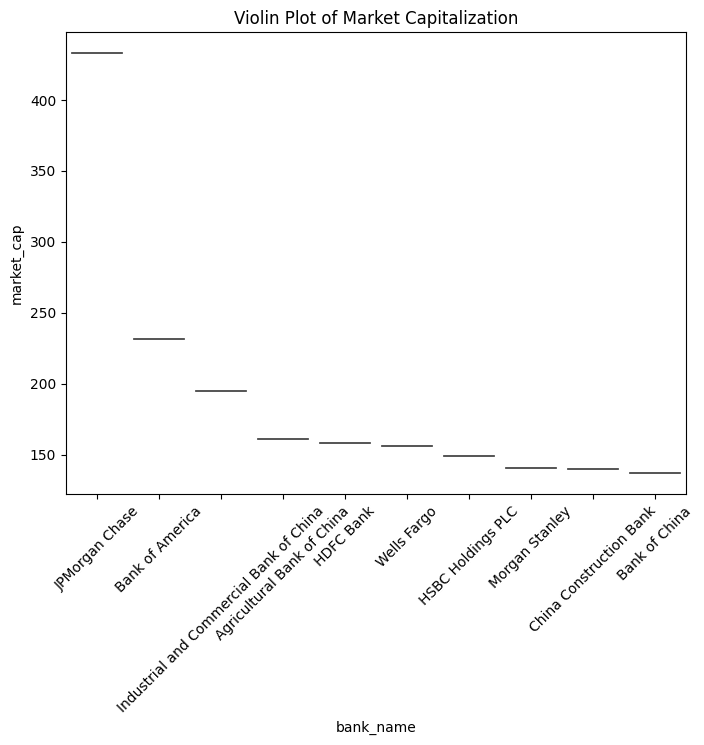

In [ ]:
# Market Cap Distribution by Quartile
plt.figure(figsize=(8,6))
sns.violinplot(x="bank_name", y="market_cap", data=df_pd, inner="quartile")
plt.title("Violin Plot of Market Capitalization")
plt.xticks(rotation=45)
plt.show()

##**3.7. Cumulative Market Share Analysis**

Compute cumulative market share and visualize it with a line plot.

+----+--------------------+----------+------------------+-----------------------+
|rank|           bank_name|market_cap|      market_share|market_share_cumulative|
+----+--------------------+----------+------------------+-----------------------+
|   1|      JPMorgan Chase|    432.92|22.787421966291543|     22.787421966291543|
|   2|     Bank of America|    231.52| 12.18641766062048|     34.973839626912024|
|   3|Industrial and Co...|    194.56|10.240970197176575|       45.2148098240886|
|   4|Agricultural Bank...|    160.68|  8.45764335568633|      53.67245317977493|
|   5|           HDFC Bank|    157.91| 8.311840069059173|       61.9842932488341|
|   6|         Wells Fargo|    155.87|  8.20446147529766|      70.18875472413175|
|   7|   HSBC Holdings PLC|     148.9|7.8375846132791525|       78.0263393374109|
|   8|      Morgan Stanley|    140.83|  7.41280752913434|      85.43914686654524|
|   9|China Constructio...|    139.82| 7.359644597909274|      92.79879146445452|
|  10|       Ban

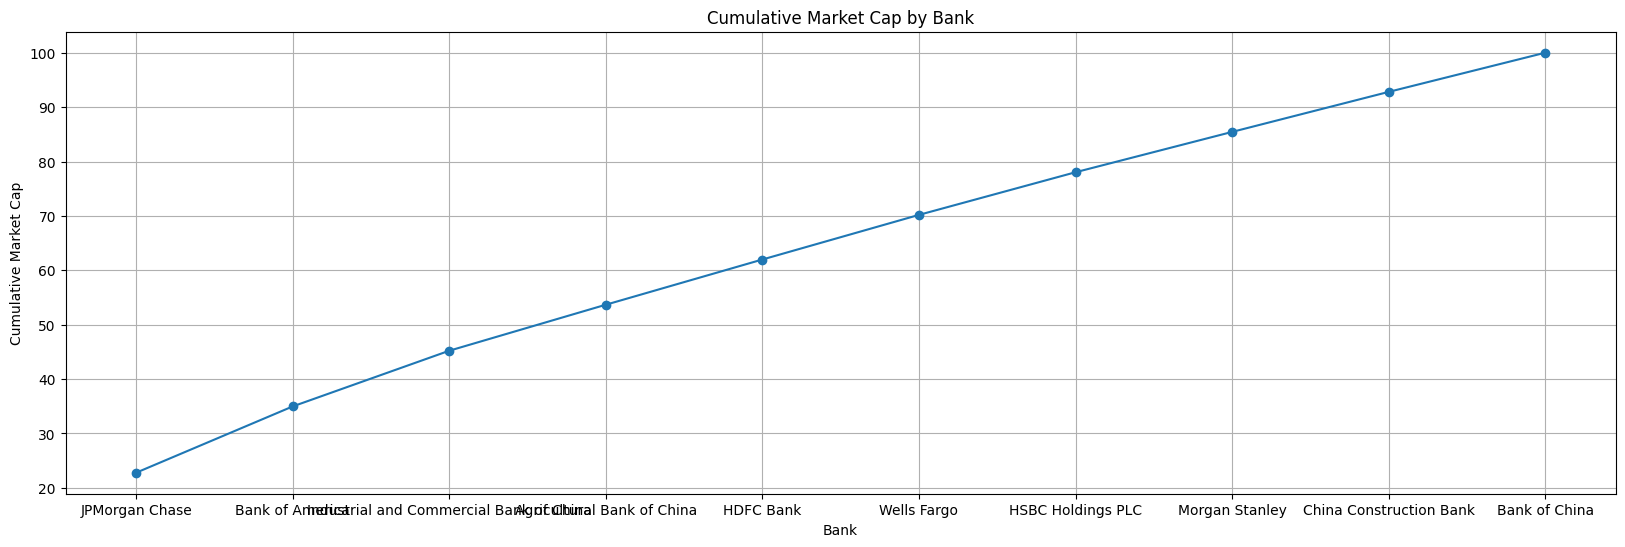

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Cumulative Market Share

# Calculate market share percentage for top 10 banks
df_pd["market_share"] = df_pd["market_cap"] / df_pd["market_cap"].sum() * 100

df_pd["market_share_cumulative"] = df_pd["market_share"].cumsum()

# Pyspark DF
# Step 1: Compute total market cap
total_cap = df_clean.agg(F.sum("market_cap").alias("TotalCap")).collect()[0]["TotalCap"]

# Step 2: Compute market share (%)
df_clean = df_clean.withColumn("market_share", (F.col("market_cap") / total_cap) * 100)

# Define a window (ordered by some column, e.g., id)
window_spec = Window.orderBy(F.desc("market_share")).rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Add cumulative column
df_clean = df_clean.withColumn("market_share_cumulative", F.sum("market_share").over(window_spec))
df_clean.show()

# --- Concentration ratios (CR3, CR5) ---
cr3 = (df_clean.orderBy(F.desc("market_share")).limit(3)
       .agg(F.sum("market_share")).collect()[0][0])
cr5 = (df_clean.orderBy(F.desc("market_share")).limit(5)
       .agg(F.sum("market_share")).collect()[0][0])

# Plot
plt.figure(figsize=(20,6))
plt.plot(df_pd["bank_name"], df_pd["market_share_cumulative"], marker="o")
plt.title("Cumulative Market Cap by Bank")
plt.xlabel("Bank")
plt.ylabel("Cumulative Market Cap")
plt.grid(True)
plt.show()


##**3.8. Categorising Banks**

Categorize banks into market capitalization ranges and analyze their distribution using a bar chart.

/tmp/ipython-input-3419041627.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="segment", y="count", data=pdf, palette="pastel", edgecolor="black")


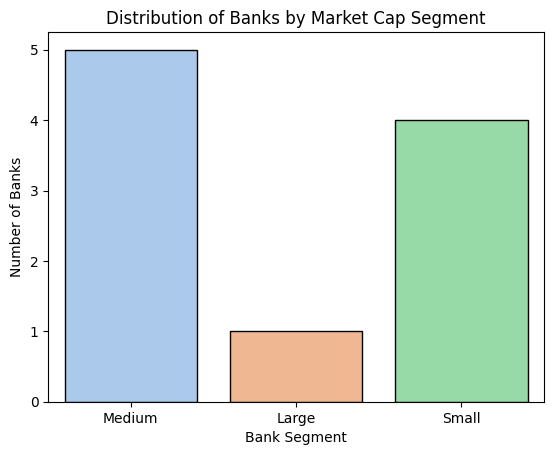

In [ ]:
# Market Cap Range Distribution
# Create market cap ranges (>=300, 150-300, <300)
df_clean = df_clean.withColumn(
    "segment",
    F.when(F.col("market_cap") >= 300, "Large")
     .when(F.col("market_cap") >= 150, "Medium")
     .otherwise("Small")
)

# Plot
# Count banks in each category
category_counts = df_clean.groupBy("segment").count()

# Convert to Pandas for plotting
pdf = category_counts.toPandas()

sns.barplot(x="segment", y="count", data=pdf, palette="pastel", edgecolor="black")
plt.xlabel("Bank Segment")
plt.ylabel("Number of Banks")
plt.title("Distribution of Banks by Market Cap Segment")
plt.show()


##**3.9. Visualise Market Share Distribution**


Calculate and display market share distribution among the top 10 banks using a pie chart.

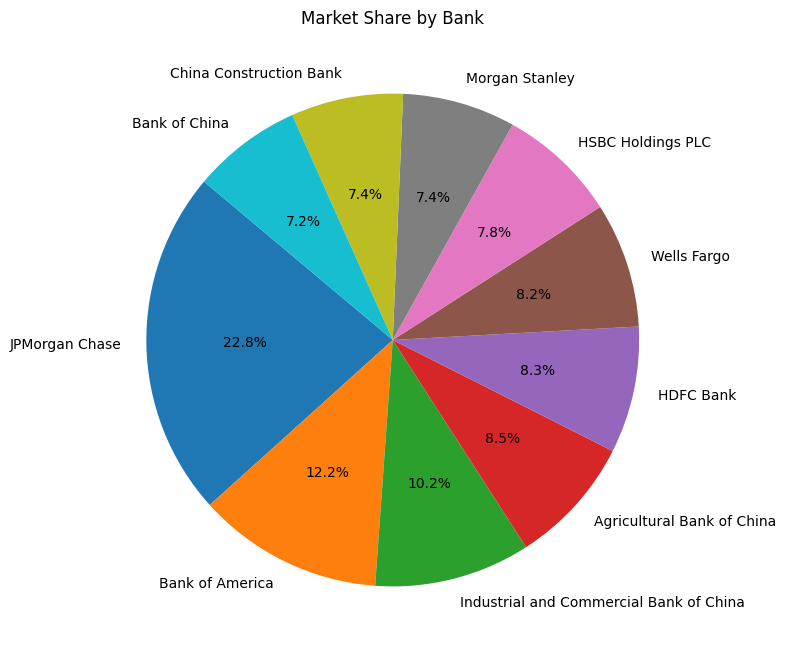

In [ ]:
# Top 10 Banks Market Share


# Plot
plt.figure(figsize=(8,8))
plt.pie(df_pd["market_cap"],
        labels=df_pd["bank_name"],
        autopct="%1.1f%%",
        startangle=140)

plt.title("Market Share by Bank")
plt.show()


#**4. ETL and Querying**

In [ ]:
#Imports & Spark Session Initialization

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, round
import logging
from datetime import datetime
import sqlite3
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("BankingDataAnalysis") \
    .getOrCreate()

# Logging Configuration
logfile = "code_log.txt"

In [ ]:
#Logging Function

def log_progress(msg):
    timeformat = '%Y-%h-%d-%H:%M:%S'
    timestamp = datetime.now().strftime(timeformat)
    with open(logfile, 'a') as f:
        f.write(f"{timestamp} : {msg}\n")

In [ ]:
# Import required functions
from pyspark.sql.functions import col, avg, sum, count, desc, asc, round, lag, dense_rank, ntile, when, first, lead
from pyspark.sql.window import Window

# First, let's rename your columns to match our queries (if needed)

# Create window specifications
window_spec = (
    Window
    .partitionBy("category")         # each region separately
    .orderBy("market_share")               # ordered by date
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)  # cumulative
)


##4.1.**Market Concentration Analysis**

Analyze Market Concentration and Categorize Banks Based on Market Share Tiers

In [ ]:
# Market Concentration Analysis
# We can see the market is moderately concentrated with top 3 banks capitalizing ~45% of the market
# Rest of the banks are close with 7-10% market cap
# There is one clear leader (>20% market cap) with a competitive cluster of mid-sized banks.
df_clean = df_clean.withColumn(
    "tier",
    F.when(F.col("market_share") > 20, "Tier 1 (>20%)")
     .when(F.col("market_share") > 10, "Tier 2 (10–20%)")
     .otherwise("Tier 3 (≤10%)")
)

df_clean.show()

+----+--------------------+----------+------------------+-----------------------+-------+---------------+
|rank|           bank_name|market_cap|      market_share|market_share_cumulative|segment|           tier|
+----+--------------------+----------+------------------+-----------------------+-------+---------------+
|   1|      JPMorgan Chase|    432.92|22.787421966291543|     22.787421966291543|  Large|  Tier 1 (>20%)|
|   2|     Bank of America|    231.52| 12.18641766062048|     34.973839626912024| Medium|Tier 2 (10–20%)|
|   3|Industrial and Co...|    194.56|10.240970197176575|       45.2148098240886| Medium|Tier 2 (10–20%)|
|   4|Agricultural Bank...|    160.68|  8.45764335568633|      53.67245317977493| Medium|  Tier 3 (≤10%)|
|   5|           HDFC Bank|    157.91| 8.311840069059173|       61.9842932488341| Medium|  Tier 3 (≤10%)|
|   6|         Wells Fargo|    155.87|  8.20446147529766|      70.18875472413175| Medium|  Tier 3 (≤10%)|
|   7|   HSBC Holdings PLC|     148.9|7.837584

##**4.2. Market Capitalization Distribution**

Examine Statistical Distribution of Market Capitalization Using Quartile Analysis

In [ ]:
# Import required functions
from pyspark.sql.functions import (col, avg, sum, count, desc, asc, round, lag,
                                 dense_rank, ntile, when, first, lead, min, max, lit)
from pyspark.sql.window import Window

# Query 3: Statistical Distribution Analysis
# Compute quartiles
quantiles = df_clean.approxQuantile("market_cap", [0.25, 0.5, 0.75], 0.0)
q1, q2, q3 = quantiles

# Add quartile category column
df_clean = df_clean.withColumn(
    "quartile",
    F.when(F.col("market_cap") <= q1, "Q1 (Small)")
     .when(F.col("market_cap") <= q2, "Q2 (Lower-Mid)")
     .when(F.col("market_cap") <= q3, "Q3 (Upper-Mid)")
     .otherwise("Q4 (Large)")
)

df_clean.show()

+----+--------------------+----------+------------------+-----------------------+-------+---------------+--------------+
|rank|           bank_name|market_cap|      market_share|market_share_cumulative|segment|           tier|      quartile|
+----+--------------------+----------+------------------+-----------------------+-------+---------------+--------------+
|   1|      JPMorgan Chase|    432.92|22.787421966291543|     22.787421966291543|  Large|  Tier 1 (>20%)|    Q4 (Large)|
|   2|     Bank of America|    231.52| 12.18641766062048|     34.973839626912024| Medium|Tier 2 (10–20%)|    Q4 (Large)|
|   3|Industrial and Co...|    194.56|10.240970197176575|       45.2148098240886| Medium|Tier 2 (10–20%)|Q3 (Upper-Mid)|
|   4|Agricultural Bank...|    160.68|  8.45764335568633|      53.67245317977493| Medium|  Tier 3 (≤10%)|Q3 (Upper-Mid)|
|   5|           HDFC Bank|    157.91| 8.311840069059173|       61.9842932488341| Medium|  Tier 3 (≤10%)|Q3 (Upper-Mid)|
|   6|         Wells Fargo|    1

##**4.3. Market Dominance Analysis** <font color = red>[6 marks]</font> <br>

Assess Market Dominance by Measuring Cumulative Share and Dominance Score

In [ ]:
# Market Dominance Analysis
# Using Herfindahl–Hirschman Index (HHI)

# Convert market share % to fraction
df_clean = df_clean.withColumn("market_share_frac", F.col("market_share") / 100)

# Compute squared market shares
df_clean = df_clean.withColumn("share_squared", F.pow(F.col("market_share_frac"), 2))

# Compute HHI
hhi_value = df_clean.agg(F.sum("share_squared").alias("HHI")).collect()[0]["HHI"]

print(f"HHI: {hhi_value:.3f}")

def interpret_hhi(x):
    if x < 0.15: return "Competitive"
    if x < 0.25: return "Moderately concentrated"
    return "Highly concentrated"

hhi_bucket = interpret_hhi(hhi_value)

HHI: 0.120


##**4.4. Segment-Wise Bank Analysis**

Q: Analyze Segment-Wise Bank Performance Based on Market Capitalization Ranges

In [ ]:
# Segment Performance Analysis
# Aggregate statistics per segment
segment_stats = df_clean.groupBy("tier").agg(
    F.count("*").alias("num_banks"),
    F.sum("market_cap").alias("total_market_cap"),
    F.avg("market_cap").alias("avg_market_cap"),
    F.max("market_cap").alias("max_market_cap"),
    F.min("market_cap").alias("min_market_cap")
)

print(segment_stats.show())

+---------------+---------+------------------+------------------+--------------+--------------+
|           tier|num_banks|  total_market_cap|    avg_market_cap|max_market_cap|min_market_cap|
+---------------+---------+------------------+------------------+--------------+--------------+
|  Tier 3 (≤10%)|        7|1040.8200000000002|148.68857142857146|        160.68|        136.81|
|  Tier 1 (>20%)|        1|            432.92|            432.92|        432.92|        432.92|
|Tier 2 (10–20%)|        2|426.08000000000004|213.04000000000002|        231.52|        194.56|
+---------------+---------+------------------+------------------+--------------+--------------+

None


##**4.5. Performance Dashboard**

Generate a Comprehensive Performance Dashboard for Bank Rankings and Metrics

In [ ]:
# Comprehensive Performance Dashboard
#   Columns: bank_name, market_cap, market_share, rank_by_share, cum_share, tier, quartile_cap, segment
df_out = df_clean.select("bank_name","market_cap","market_share","rank","market_share_cumulative","tier","quartile","segment")

# NOTE: If running locally, adapt the path
out_path = "/content/drive/MyDrive/upgrad/BankingAnalysis/bank_metrics.csv"
df_out.coalesce(1).write.mode("overwrite").option("header", True).csv(out_path)

# Save summary KPIs (small single-row table)
summary = spark.createDataFrame(
    [(float(total_cap), float(cr3), float(cr5), float(hhi_value), hhi_bucket)],
    ["total_cap","CR3","CR5","HHI","HHI_bucket"]
)

summary_path = "/content/drive/MyDrive/upgrad/BankingAnalysis/bank_summary.csv"
summary.coalesce(1).write.mode("overwrite").option("header", True).csv(summary_path)

#5. Visualization Integration

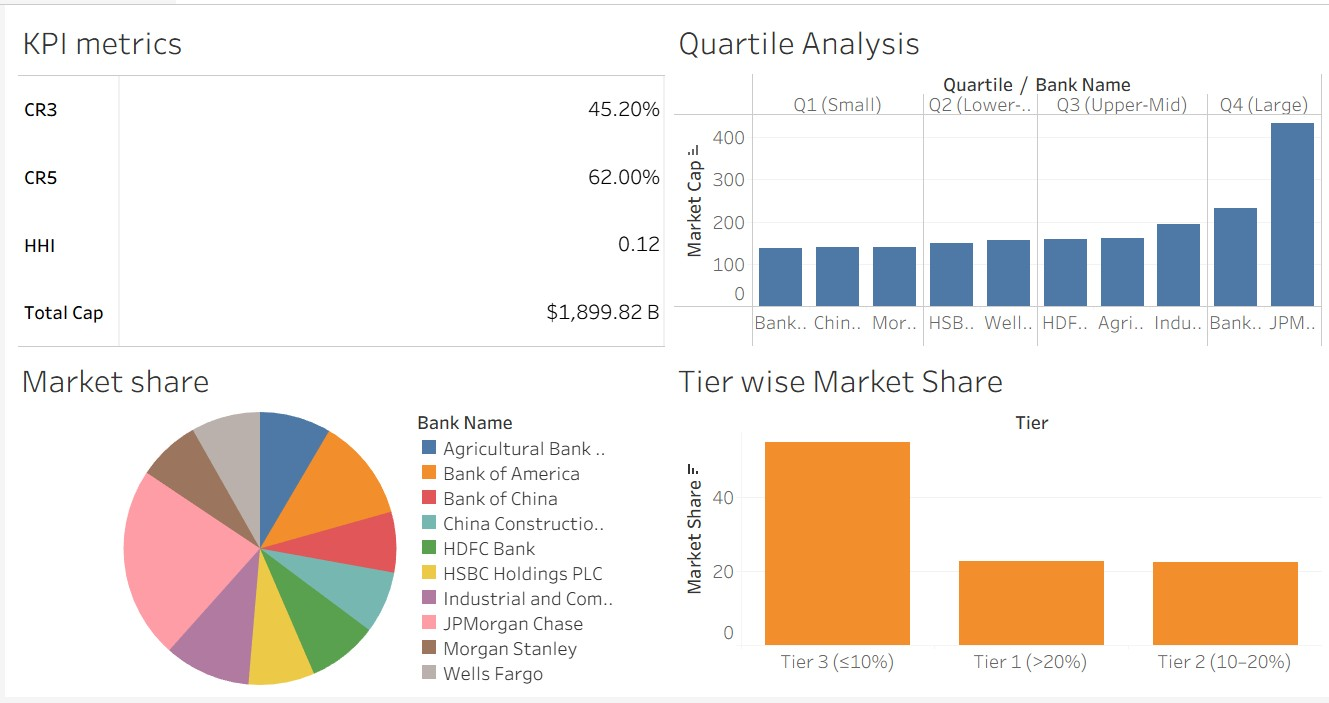